# hdWGCNA: Pipeline

## Examples

### ENCODE 4 mouse adrenal tissue

In [1]:
%%bash
rds_obj="/cellar/users/aklie/data/igvf/topic_grn_links/mouse_adrenal/preprocess/snrna/normalized.rds"
name="normalized_adrenal"
out_dir="/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/hdwgcna/results/mouse_adrenal"
cd scripts
sbatch --job-name=hdWGCNA_adrenal --cpus-per-task=4 --mem=128G hdWGCNA.sh $rds_obj $name $out_dir

Submitted batch job 214886


### ENCODE 4 mouse heart tissue

In [2]:
%%bash
rds_obj="/cellar/users/aklie/data/igvf/topic_grn_links/mouse_heart/preprocess/snrna/normalized.rds"
name="normalized_heart"
out_dir="/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/hdwgcna/results/mouse_heart"
cd scripts
sbatch --job-name=hdWGCNA_heart --cpus-per-task=4 --mem=128G hdWGCNA.sh $rds_obj $name $out_dir

Submitted batch job 214887


### Endothelial cell perturb-seq

In [2]:
%%bash
rds_obj="/cellar/users/aklie/data/igvf/topic_grn_links/endothelial_perturb_seq/preprocess/normalized.rds"
name="normalized_endothelial"
out_dir="/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/hdwgcna/results/endothelial_perturb_seq"
cd scripts
sbatch --job-name=hdWGCNA_endothelial --cpus-per-task=4 --mem=128G hdWGCNA.sh $rds_obj $name $out_dir

Submitted batch job 215147


# hdWGCNA: Step-by-step

In [1]:
# Conversion libraries and Seurat
library(SeuratDisk)
library(SeuratData)
library(Seurat)
library(Signac)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Attaching SeuratObject

Attaching sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::reduce() masks Signac::reduce()


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [4]:
# Parameters
NN <- 25
GENES <- "all"
TARGET_CELLS = 1000

In [2]:
# Files and directories
RDS_OBJ = "/cellar/users/aklie/data/igvf/topic_grn_links/endothelial_perturb_seq/preprocess/subset/normalized.rds"
NAME = "normalized_subset"
OUT = "/cellar/users/aklie/projects/igvf/topic_grn_links/grn_inference/mouse_adrenal/hdwgcna/result/"

In [3]:
# Read in the R object
seurat_obj <- readRDS(RDS_OBJ)
seurat_obj

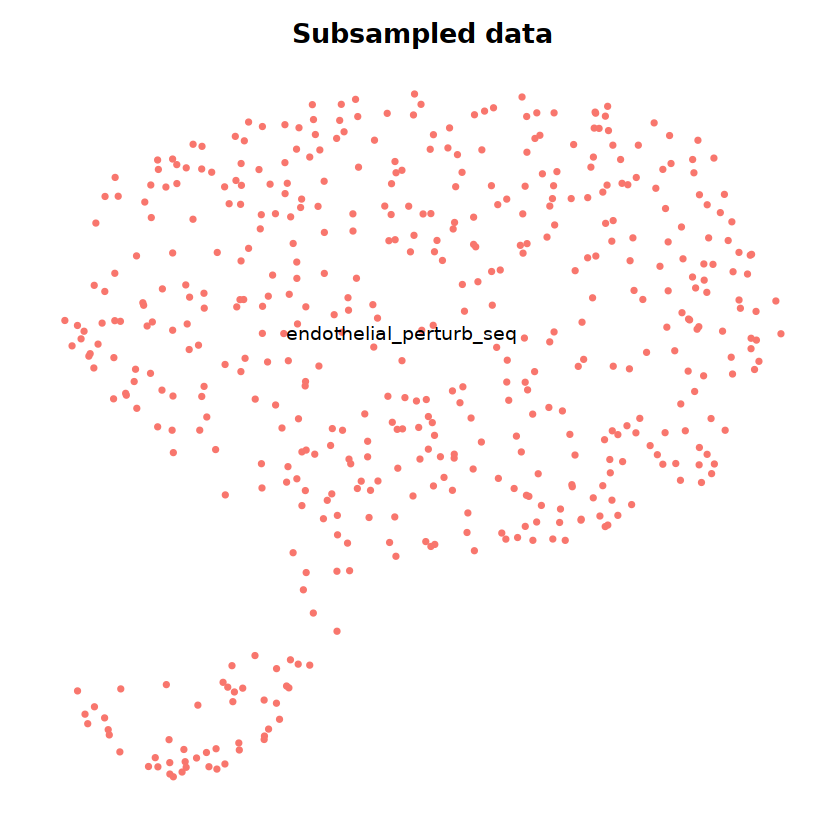

In [6]:
# Plot UMAP
p1 <- DimPlot(seurat_obj, group.by='celltypes', reduction="umap", label=TRUE) +
   umap_theme() + ggtitle('Subsampled data') + NoLegend()
p1

In [7]:
# Check colnames available
DefaultAssay(seurat_obj) <- "RNA"
colnames(seurat_obj[[]])

In [9]:
# Set-up a Seurat object for WGCNA
seurat_obj <- SetupForWGCNA(
    seurat_obj,
    gene_select = "fraction", # the gene selection approach
    fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
    wgcna_name = NAME # the name of the hdWGCNA experiment
)

In [10]:
# Construct metacells n each group
seurat_obj <- MetacellsByGroups(
  seurat_obj=seurat_obj,
  group.by=c("celltypes"), # specify the columns in adata@meta.data to group by
  k=NN, # nearest-neighbors parameter
  max_shared=10, # maximum number of shared cells between two metacells
  ident.group='celltypes', # set the Idents of the metacell seurat object
  assay="RNA",
  slot="counts",
  target_metacells=TARGET_CELLS,
)

[1] "done making metacells"
[1] 1
[1] "metacell shape"


In [11]:
# transpose the matrix, taking care of the
seurat_obj <- SetDatExpr(
    seurat_obj, 
    assay="RNA", 
    use_metacells=TRUE, 
    wgcna_name=NAME, 
    slot="data"
)

In [12]:
# Test different soft powers:
seurat_obj <- TestSoftPowers(
  seurat_obj,
  use_metacells=TRUE,  # this is the default, I'm just being explicit
  setDatExpr=FALSE  # set this to FALSE since we did this above
)

pickSoftThreshold: will use block size 4649.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4649 of 9622


Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 4650 through 9298 of 9622


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   ..working on genes 9299 through 9622 of 9622


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.6990  8.720          0.981 6080.00  6130.000   7190
2      2   0.4820  2.920          0.969 3930.00  3960.000   5490
3      3   0.2020  1.100          0.955 2590.00  2590.000   4270
4      4   0.0046  0.118          0.941 1740.00  1710.000   3380
5      5   0.0956 -0.478          0.941 1200.00  1140.000   2710
6      6   0.3330 -0.889          0.953  834.00   771.000   2200
7      7   0.5160 -1.150          0.966  592.00   525.000   1810
8      8   0.6280 -1.350          0.965  426.00   360.000   1500
9      9   0.7110 -1.480          0.973  312.00   248.000   1260
10    10   0.7620 -1.590          0.974  231.00   173.000   1060
11    12   0.8170 -1.710          0.974  132.00    85.200    775
12    14   0.8510 -1.740          0.976   78.90    43.100    580
13    16   0.8750 -1.740          0.982   49.10    22.200    443
14    18   0.8770 -1.730          0.976   31.70    11.600    345
15    20   0.8960 -1.680 

In [13]:
# get the power table, can also access with head(get(NAME, seurat_obj@misc)$wgcna_powerTable)
power_table <- GetPowerTable(seurat_obj)
power <- power_table$Power[which(power_table$SFT.R.sq > 0.85)[1]]

In [15]:
# construct co-expression network:
seurat_obj <- ConstructNetwork(
  seurat_obj, 
  soft_power=power,
  use_metacells=TRUE,
  setDatExpr=FALSE,
  tom_out_dir=OUT,
  tom_name=NAME # name of the topoligical overlap matrix written to disk
)

 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


In [18]:
# compute all MEs in the full single-cell dataset
seurat_obj <- ModuleEigengenes(seurat_obj, assay="RNA", verbose=FALSE)

[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_”


[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaturquoise_”


[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablue_”


[1] "brown"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcabrown_”


In [55]:
# compute eigengene-based connectivity (kME):
seurat_obj <- ModuleConnectivity(
    seurat_obj,
    assay=ASSAY,
    slot="data",
    harmonized=FALSE
)

Warning message in bicor(datExpr, datME, , use = "p"):
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


In [58]:
# Save the fully processed Seurat object to be used in all the other notebooks
saveRDS(seurat_obj, file=file.path(OUT, paste0(NAME, "_hdWGCNA.rds")))

---

# Scratch